In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

In [2]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"

In [7]:
flies = ['fly_086', 'fly_087', 'fly_089', 'fly_092', 'fly_093', 'fly_094', 'fly_095', 'fly_096',
         'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_103', 'fly_104', 'fly_105', 'fly_106',
         'fly_107', 'fly_110', 'fly_111']

In [8]:
len(flies)

20

In [47]:
directory = os.path.join(dataset_path, 'fly_098', 'func_0','fictrac')

In [48]:
fictrac_raw = bbb.load_fictrac(directory)
resolution = 10 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    fictrac[short] = bbb.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
xnew = np.arange(0,expt_len,resolution)


~~ load_fictrac ~~
load_fictrac done. Duration: 3.19 sec


In [49]:
len(fictrac['Y'])

180000

(-400, 400)

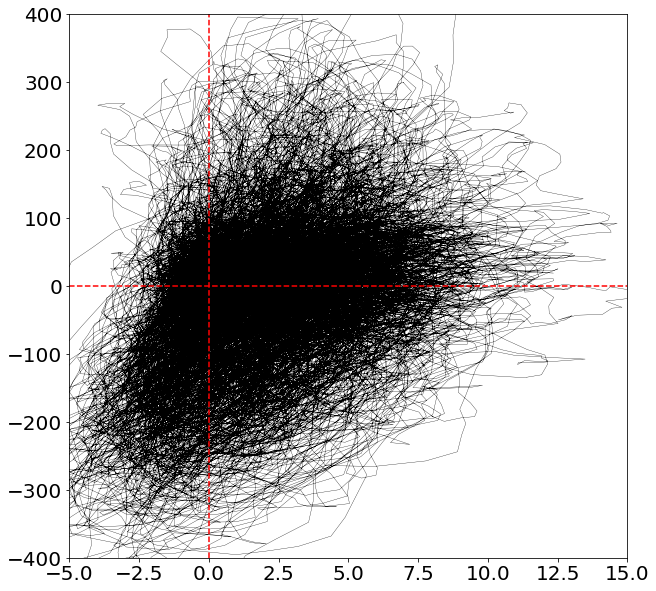

In [51]:
plt.figure(figsize=(10,10))
plt.plot(fictrac['Y'][30000:], fictrac['Z'][30000:],linewidth=.3,color='k')
plt.axvline(0,linestyle='--',color='r')
plt.axhline(0,linestyle='--',color='r')
plt.xlim(-5,15)
plt.ylim(-400,400)

In [9]:


make_2d_hist(fictrac, directory, full_id, save=True, fixed_crop=True)
make_2d_hist(fictrac, directory, full_id, save=True, fixed_crop=False)
make_velocity_trace(fictrac, directory, full_id, xnew, save=True)

def make_2d_hist(fictrac, fictrac_folder, full_id, save=True, fixed_crop=True):
    plt.figure(figsize=(10,10))
    norm = mpl.colors.LogNorm()
    plt.hist2d(fictrac['Y'],fictrac['Z'],bins=100,cmap='Blues',norm=norm);
    plt.ylabel('Rotation, deg/sec')
    plt.xlabel('Forward, mm/sec')
    plt.title('Behavior 2D hist {}'.format(full_id))
    plt.colorbar()
    name = 'fictrac_2d_hist.png'
    if fixed_crop:
        plt.ylim(-400,400)
        plt.xlim(-10,15)
        name = 'fictrac_2d_hist_fixed.png'
    if save:
        fname = os.path.join(fictrac_folder, name)
        plt.savefig(fname,dpi=100,bbox_inches='tight')

NameError: name 'fictrac_raw' is not defined

In [3]:
fly = "fly_094"
directory = os.path.join(dataset_path,fly,'func_0')
clustering_dir = os.path.join(directory, 'super_voxels')
if not os.path.exists(clustering_dir):
        os.mkdir(clustering_dir)

In [4]:
## FINALLY, THIS ONE WORKS
brain_file = os.path.join(directory, 'brain_zscored_green_high_pass_masked.nii')
brain = np.array(nib.load(brain_file).get_data(), copy=True)

In [45]:
one_slice = brain[:,:,20,:].reshape(-1, brain.shape[-1])

In [474]:
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac_raw = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 92.09 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.40 sec


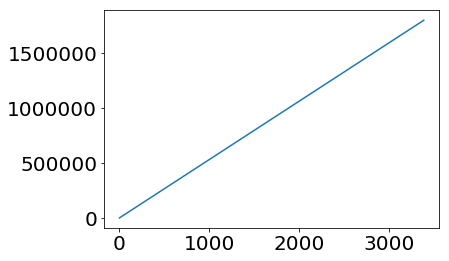

In [521]:
plt.plot(timestamps[:,20])
plt.plot(timestamps[:,20]-1000)

In [528]:
timestamps[:,25]-timestamps[:,20]

array([43.606205, 43.606205, 43.606205, ..., 43.606205, 43.606205,
       43.606205])

In [605]:
def smooth_and_interp_fictrac(fictrac, fps, resolution, expt_len, behavior, timestamps=None, smoothing=25):
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    
    x_original = np.arange(0,expt_len,camera_rate)
    fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(fictrac[behavior]),smoothing,3)
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res

    if timestamps is None:
      fictrac_interp = fictrac_interp_temp(xnew)
    else:
      fictrac_interp = fictrac_interp_temp(timestamps[:,20])

    # convert units for common cases
    sphere_radius = 4.5e-3 # in m
    if behavior in ['dRotLabY']:
        ''' starts with units of rad/frame
        * sphere_radius(m); now in m/frame
        * fps; now in m/sec
        * 1000; now in mm/sec '''
        
        fictrac_interp = fictrac_interp * sphere_radius * fps * 1000 # now in mm/sec
        
    if behavior in ['dRotLabZ']:
        ''' starts with units of rad/frame
        * 180 / np.pi; now in deg/frame
        * fps; now in deg/sec '''
        
        fictrac_interp = fictrac_interp * 180 / np.pi * fps
    
    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

In [606]:
resolution = 100 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    fictrac[short] = smooth_and_interp_fictrac(fictrac_raw,
                                                   fps,
                                                   resolution,
                                                   expt_len,
                                                   behavior,
                                                   timestamps=timestamps,
                                                   smoothing=51)
    fictrac[short] = fictrac[short]/np.std(fictrac[short])
xnew = np.arange(0,expt_len,resolution)

In [10]:
# for behavior in ['Y', 'Z']:
#     fictrac_std = np.std(fictrac[behavior])
#     fictrac[behavior] = np.divide(fictrac[behavior],fictrac_std)

In [ ]:
# LOOP
Y_glm = fictrac['Y']
#n_clusters = [9856,9000,8000,7000,6000,5000,4000,3000,2000,1500,1000,750,500,100,10,1]
#n_clusters = [77*128,5000,2000,1500,1000,750,500,100,1]
n_clusters = [8938]
#n_clusters = [1,1000,2000,4000]

#scores = {}
#maps = {}
#alphas = {}

for cluster in n_clusters[::-1]:
    t0 = time.time()
    print('working on cluster {}'.format(cluster))
    model = AgglomerativeClustering(n_clusters=cluster,
                                    memory=clustering_dir,
                                    linkage='ward',
                                    connectivity=connectivity)
    model = model.fit(one_slice_eroded)

    signals = []
    for cluster_num in range(cluster):
        cluster_indicies = np.where(model.labels_==cluster_num)[0]
        mean_signal = np.mean(one_slice_eroded[cluster_indicies,:], axis=0)
        signals.append(mean_signal)
    X_glm=np.asarray(signals).T

    modelglm = RidgeCV(alphas=[1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7])
    modelglm.fit(X_glm, Y_glm)
    
    colored_by_betas = np.zeros(77*128)
    for cluster_num in range(cluster):
        cluster_indicies = np.where(model.labels_==cluster_num)[0]
        colored_by_betas[cluster_indicies] = modelglm.coef_[cluster_num]
    colored_by_betas = colored_by_betas.reshape(77,128)
    
    maps[cluster] = colored_by_betas
    scores[cluster] = modelglm.score(X_glm, Y_glm)
    alphas[cluster] = modelglm.alpha_
    
    print('duration {:.0f}s'.format(time.time()-t0))

In [64]:
256*128

32768

In [43]:
from sklearn.feature_extraction.image import grid_to_graph
connectivity = grid_to_graph(256,128)

In [65]:
n_clusters = 10000 #2000
model = AgglomerativeClustering(n_clusters=n_clusters,
                                memory=clustering_dir,
                                linkage='ward',
                                connectivity=connectivity)
model = model.fit(one_slice)

In [66]:
signals = []
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(model.labels_==cluster_num)[0]
    mean_signal = np.mean(one_slice[cluster_indicies,:], axis=0)
    signals.append(mean_signal)
signals=np.asarray(signals)

In [492]:
timestamps[:,20]

array([2.79079712e+02, 8.11075413e+02, 1.34307111e+03, ...,
       1.79895654e+06, 1.79948854e+06, 1.80002054e+06])

In [588]:
### For Acceleration ###

### First, get high_res behavior ###
resolution = 10 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    fictrac[short] = bbb.smooth_and_interp_fictrac(fictrac_raw,
                                                   fps,
                                                   resolution,
                                                   expt_len,
                                                   behavior,
                                                   timestamps=None,
                                                   smoothing=51)
    fictrac[short] = fictrac[short]/np.std(fictrac[short])
xnew = np.arange(0,expt_len,resolution)

### Differentiate and smooth ###
accel = scipy.signal.savgol_filter(np.diff(fictrac['Y']),25,3)
accel = np.append(accel, 0)

### Interpolate to neural data ###
expt_len = 1000*30*60
fps = 100 #of fictrac camera
camera_rate = 1/fps * 1000 # camera frame rate in ms
x_original = np.arange(0,expt_len,camera_rate)
fictrac_interp_temp = interp1d(x_original, accel, bounds_error = False)
acl = fictrac_interp_temp(timestamps[:,20])
acl[-1] = 0

# corrs = []
# for i in range(n_clusters):
#     corrs.append(scipy.stats.pearsonr(acl, signals[i,:])[0])
    
# colored_by_betas = np.zeros(256*128)
# for cluster_num in range(n_clusters):
#     cluster_indicies = np.where(model.labels_==cluster_num)[0]
#     colored_by_betas[cluster_indicies] = corrs[cluster_num]
# colored_by_betas = colored_by_betas.reshape(256,128)

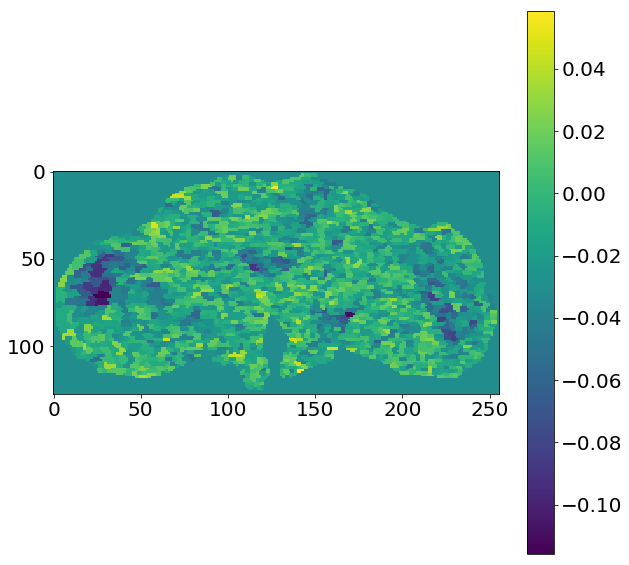

In [105]:
plt.figure(figsize=(10,10))
plt.imshow(colored_by_betas.T)
plt.colorbar()

In [108]:
corrs = []
for i in range(n_clusters):
    corrs.append(scipy.stats.pearsonr(fictrac['Y'], signals[i,:])[0])

In [113]:
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(model.labels_==cluster_num)[0]
    #colored_by_betas[cluster_indicies] = np.random.randint(1,100) #assign corrs here instead.
    colored_by_betas[cluster_indicies] = corrs[cluster_num] #assign corrs here instead.
colored_by_betas = colored_by_betas.reshape(256,128)

In [112]:
colored_by_betas.shape

(256, 128)

In [118]:
np.argmax(corrs)

1557

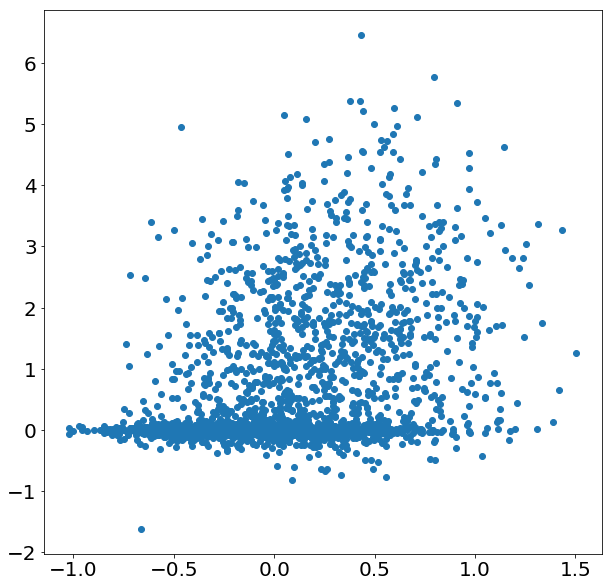

In [133]:
plt.figure(figsize=(10,10))
plt.plot(signals[np.argmax(corrs),:], fictrac['Y'],'o')

(0, 500)

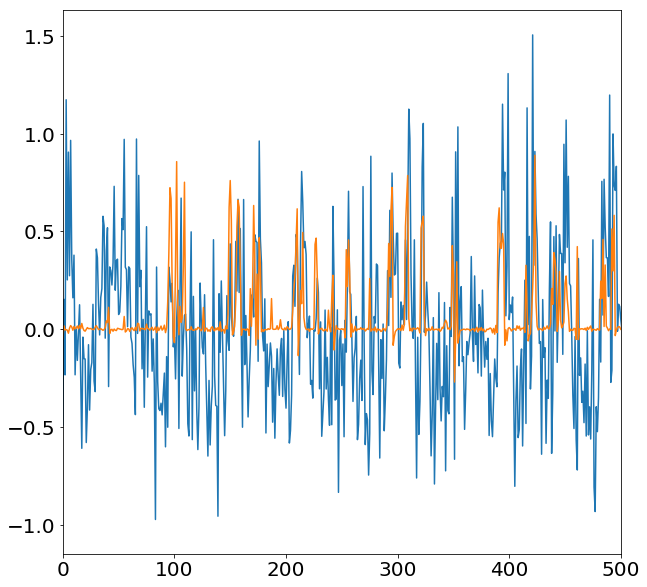

In [143]:
plt.figure(figsize=(10,10))
plt.plot(signals[np.argmax(corrs),:])
plt.plot(fictrac['Y']/6)
#plt.plot(fictrac['Z']/6)
plt.xlim(0,500)

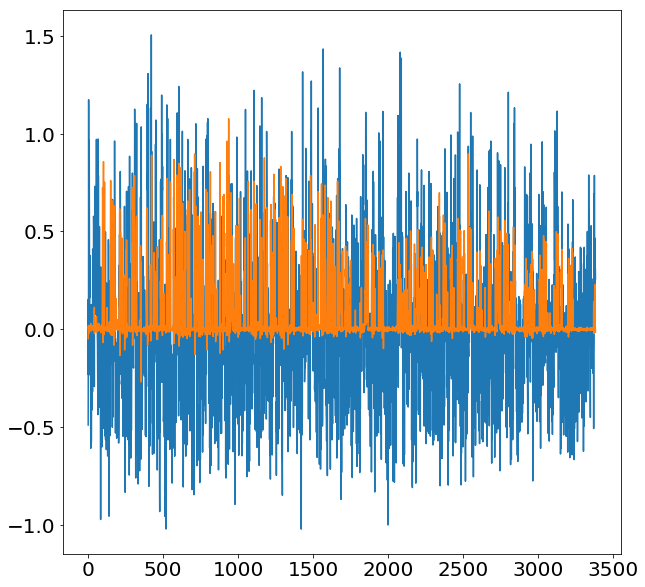

In [131]:
plt.figure(figsize=(10,10))
plt.plot(signals[np.argmax(corrs),:])
plt.plot(fictrac['Y']/6)

In [117]:
np.shape(corrs)

(2000,)

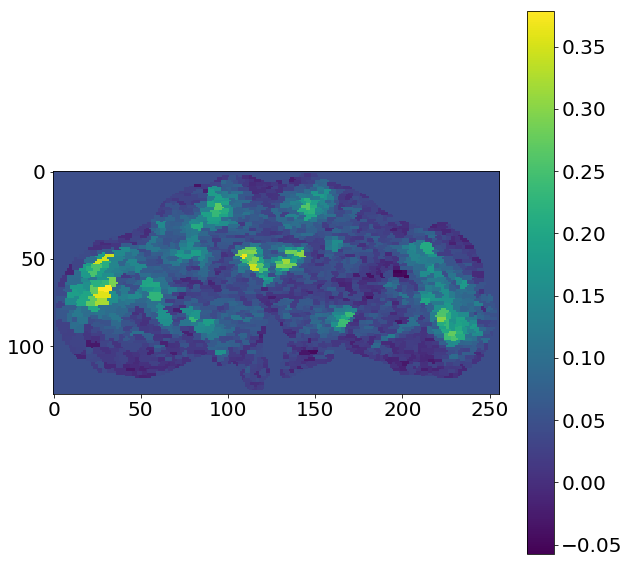

In [110]:
plt.figure(figsize=(10,10))
plt.imshow(colored_by_betas.T)
plt.colorbar()

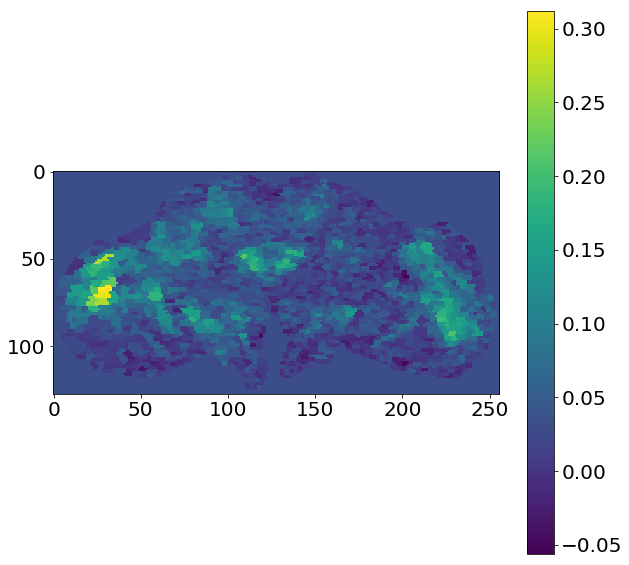

In [54]:
plt.figure(figsize=(10,10))
plt.imshow(colored_by_betas.T)
plt.colorbar()

In [62]:
signals.shape

(500, 4731)

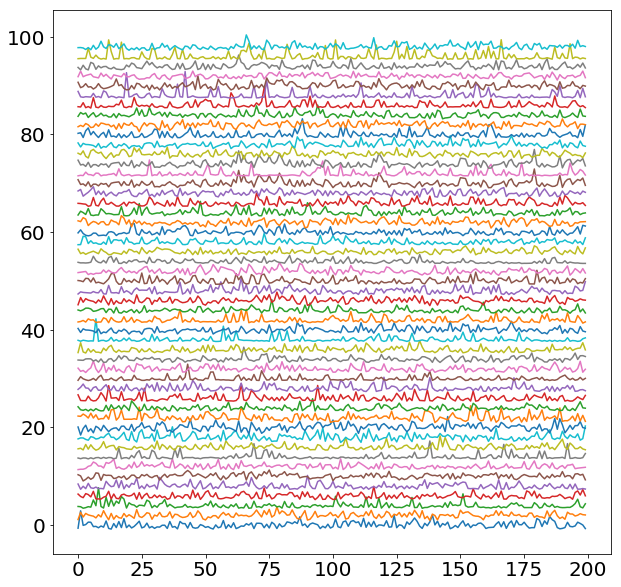

In [75]:
### quick plot
plt.figure(figsize=(10,10))
for i,cluster in enumerate(np.random.randint(0,500,50)):
    plt.plot(signals[cluster,2000:2200]+i*2);

In [ ]:
signals = []
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(model.labels_==cluster_num)[0]
    mean_signal = np.mean(one_slice[cluster_indicies,:], axis=0)
    signals.append(mean_signal)
    
signals=np.asarray(signals)

signals.shape

### quick plot
plt.figure(figsize=(10,10))
for i,cluster in enumerate(np.random.randint(0,2000,50)):
    plt.plot(signals[cluster,2000:2200]+i*2);

In [ ]:
### CLUSTER ###
n_clusters = [9856,9000,8000,7000,6000,5000,4000,3000,2000,1500,1000,750,500,100,10,1]
for cluster in n_clusters:
    model = AgglomerativeClustering(n_clusters=cluster,
                                memory=clustering_dir,
                                linkage='complete',
                                connectivity=None)
    model = model.fit(one_slice)

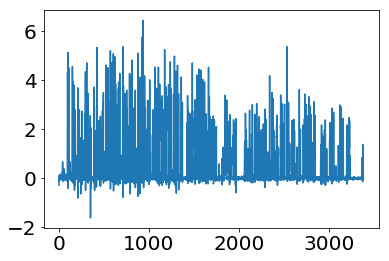

In [32]:
plt.plot(fictrac['Y'])

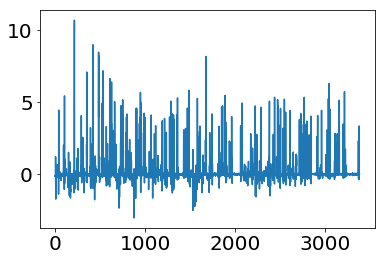

In [33]:
plt.plot(fictrac['Z'])

In [36]:
resolution = 10 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    fictrac[short] = bbb.smooth_and_interp_fictrac(fictrac_raw,
                                                   fps,
                                                   resolution,
                                                   expt_len,
                                                   behavior,
                                                   timestamps=None,
                                                   smoothing=51)
    fictrac[short] = fictrac[short]/np.std(fictrac[short])
xnew = np.arange(0,expt_len,resolution)

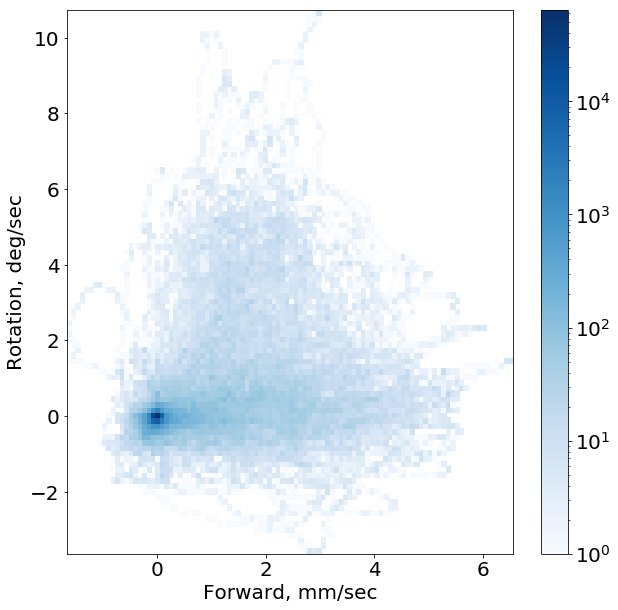

In [37]:
plt.figure(figsize=(10,10))
norm = mpl.colors.LogNorm()
plt.hist2d(fictrac['Y'],fictrac['Z'],bins=100,cmap='Blues',norm=norm);
plt.ylabel('Rotation, deg/sec')
plt.xlabel('Forward, mm/sec')
plt.colorbar()

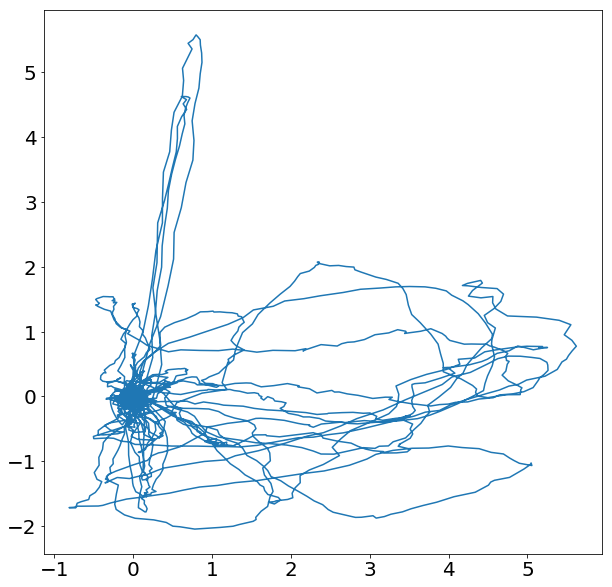

In [48]:
plt.figure(figsize=(10,10))
plt.plot(fictrac['Y'][:10000],fictrac['Z'][:10000])

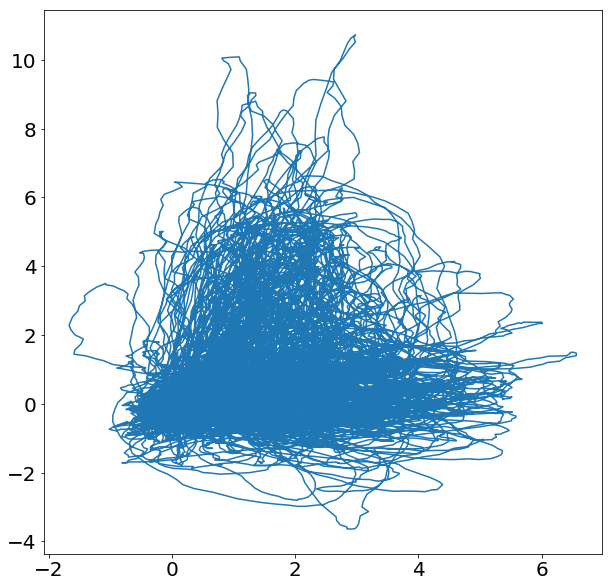

In [49]:
plt.figure(figsize=(10,10))
plt.plot(fictrac['Y'],fictrac['Z'])

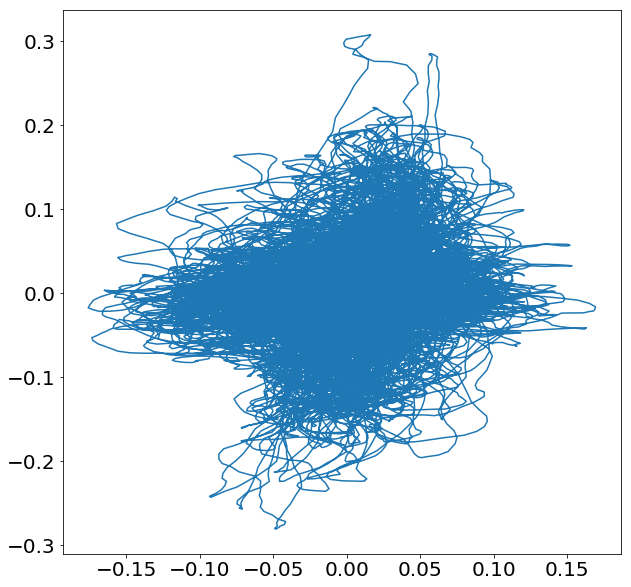

In [53]:
plt.figure(figsize=(10,10))
plt.plot(scipy.signal.savgol_filter(diff(fictrac['Y']),25,3),
         scipy.signal.savgol_filter(diff(fictrac['Z']),25,3))

In [40]:
len(fictrac['Y'])

180000

In [41]:
from numpy import diff

In [51]:
out = scipy.signal.savgol_filter(dy,25,3)

(50000, 51000)

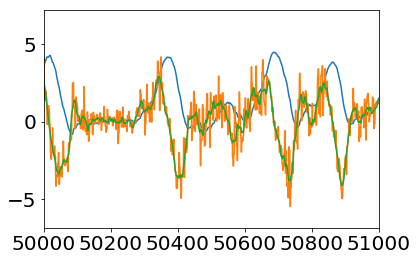

In [52]:
plt.plot(fictrac['Y'])
plt.plot(dy*30)
plt.plot(out*30)
plt.xlim(50000,51000)

In [42]:
dy = diff(fictrac['Y'])

In [ ]:
# want to make a new vector that encodes "straigness".
# 

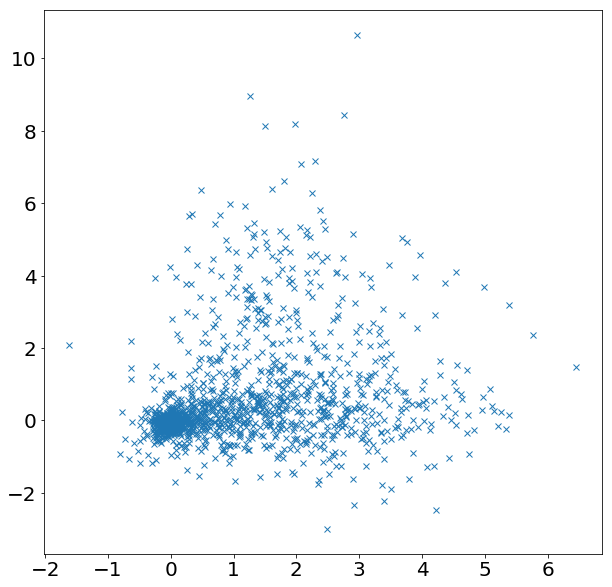

In [10]:
plt.figure(figsize=(10,10))
plt.plot(fictrac['Y'],fictrac['Z'],'x')

In [16]:
# create bounding boxes
forward_min = 1
forward_max = 5
forward_width = 1

f1 = np.where(fictrac['Y']>.5)[0]
f2 = np.where(np.abs(fictrac['Z'])<forward_width)[0]
f3 = np.where(fictrac['Y']<1.5)[0]
forward_times_1 = [i for i in f1 if i in f2 and i in f3]

f1 = np.where(fictrac['Y']>1.5)[0]
f2 = np.where(np.abs(fictrac['Z'])<forward_width)[0]
f3 = np.where(fictrac['Y']<2.5)[0]
forward_times_2 = [i for i in f1 if i in f2 and i in f3]

f1 = np.where(fictrac['Y']>2.5)[0]
f2 = np.where(np.abs(fictrac['Z'])<forward_width)[0]
f3 = np.where(fictrac['Y']<3.5)[0]
forward_times_3 = [i for i in f1 if i in f2 and i in f3]

f1 = np.where(fictrac['Y']>3.5)[0]
f2 = np.where(np.abs(fictrac['Z'])<forward_width)[0]
f3 = np.where(fictrac['Y']<4.5)[0]
forward_times_4 = [i for i in f1 if i in f2 and i in f3]

print(len(forward_times_1),
      len(forward_times_2),
      len(forward_times_3),
      len(forward_times_4))

209 134 83 36


In [90]:
# create bounding boxes
forward_min = 3
forward_max = 7
forward_width = 1

rotation_min = 2
rotation_max = 10
rotation_forward_bias = 3
rotation_reverse_bias = 0

stop_r = 0.2

f1 = np.where(fictrac['Y']>forward_min)[0]
f2 = np.where(np.abs(fictrac['Z'])<forward_width)[0]
f3 = np.where(fictrac['Y']<forward_max)[0]
forward_times = [i for i in f1 if i in f2 and i in f3]

r1 = np.where(fictrac['Z']>rotation_min)[0]
r2 = np.where(fictrac['Z']<rotation_max)[0]
r3 = np.where(fictrac['Y']>rotation_reverse_bias)[0]
r4 = np.where(fictrac['Y']<rotation_forward_bias)[0]
rotation_pos_times = [i for i in r1 if i in r2 and i in r3 and i in r4]

r1 = np.where(fictrac['Z']<-rotation_min)[0]
r2 = np.where(fictrac['Z']>-rotation_max)[0]
r3 = np.where(fictrac['Y']>rotation_reverse_bias)[0]
r4 = np.where(fictrac['Y']<rotation_forward_bias)[0]
rotation_neg_times = [i for i in r1 if i in r2 and i in r3 and i in r4]

rotation_times = rotation_pos_times + rotation_neg_times

stop_times = np.where(fictrac['Y']**2 + fictrac['Z']**2 < stop_r**2)[0]

print(len(forward_times), len(rotation_pos_times), len(rotation_neg_times), len(stop_times), len(rotation_times))

90 158 2 2219 160


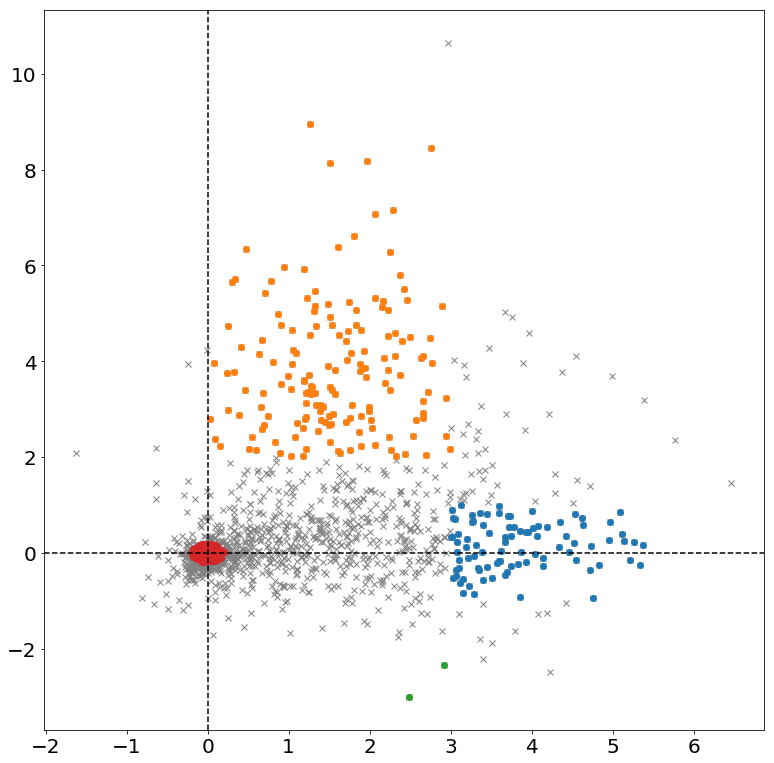

In [91]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
x=fictrac['Y']
y=fictrac['Z']
ax.plot(x,y,color='grey',marker='x',linestyle='')
ax.plot(x[forward_times],y[forward_times],marker='o',linestyle='None')
ax.plot(x[rotation_pos_times],y[rotation_pos_times],marker='o',linestyle='None')
ax.plot(x[rotation_neg_times],y[rotation_neg_times],marker='o',linestyle='None')
ax.plot(x[stop_times],y[stop_times],marker='o',linestyle='None')


ax.axvline(0, linestyle='--', color='k')
ax.axhline(0, linestyle='--', color='k')

In [38]:
len(rotation_pos_times)

174

In [26]:
brain.shape

(256, 128, 49, 3384)

In [565]:
one_slice = one_slice.reshape(256,128,3384)

In [564]:
one_slice.shape

(32768, 3384)

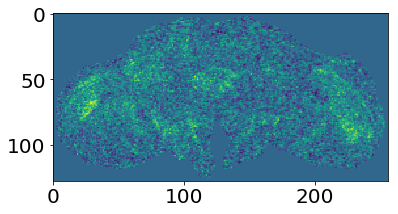

In [566]:
plt.imshow(np.mean(one_slice[:,:,rotation_pos_times],axis=-1).T)

In [567]:
out = np.mean(signals[:,rotation_pos_times],axis=-1)

In [568]:
np.argmax(np.nan_to_num(out))

5017

In [48]:
signals.shape

(2000, 3384)

In [86]:
moving_times = [i for i in range(3384) if i not in stop_times]

In [100]:
out.shape

(10000,)

In [101]:
np.argmax(out)

2083

In [104]:
signals.shape

(10000, 3384)

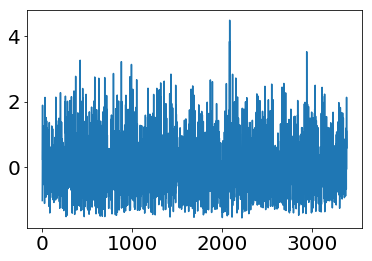

In [570]:
plt.plot(signals[5017,:])

(500, 1000)

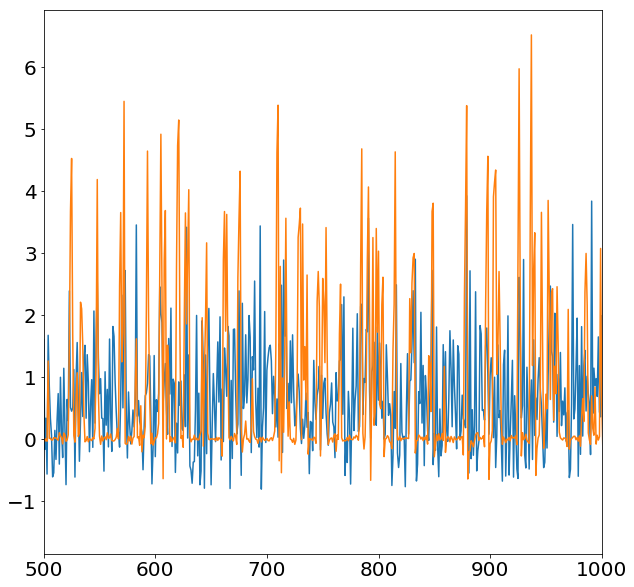

In [569]:
fig = plt.figure(figsize=(10,10))
plt.plot(signals[5017,:]+.7)
plt.plot(fictrac['Y'])
plt.xlim(500,1000)

In [96]:
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(model.labels_==cluster_num)[0]
    #colored_by_betas[cluster_indicies] = np.random.randint(1,100) #assign corrs here instead.
    colored_by_betas[cluster_indicies] = out[cluster_num] #assign corrs here instead.
colored_by_betas = colored_by_betas.reshape(256,128)

In [571]:
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(model.labels_==cluster_num)[0]
    #colored_by_betas[cluster_indicies] = np.random.randint(1,100) #assign corrs here instead.
    if cluster_num == np.argmax(out):
        colored_by_betas[cluster_indicies] = 1
    else:
        colored_by_betas[cluster_indicies] = 0
colored_by_betas = colored_by_betas.reshape(256,128)

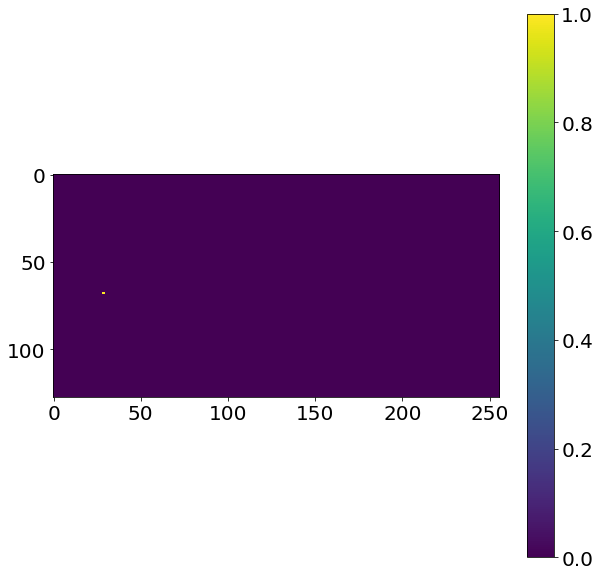

In [572]:
plt.figure(figsize=(10,10))
plt.imshow(colored_by_betas.T)
plt.colorbar()

In [148]:
signals.shape

(10000, 3384)

In [157]:
list(range(0,10,2))

[0, 2, 4, 6, 8]

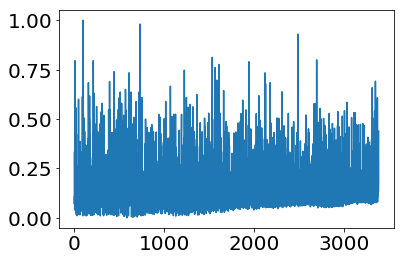

In [170]:
plt.plot(normalized)

In [573]:
x = signals[5017,:] #optic lobe
#x = signals[2083,:] #FB
normalized = (x-np.min(x))/(np.max(x)-np.min(x))

In [177]:
norm = mpl.colors.Normalize(vmin=0, vmax=.5)

In [183]:
m.to_rgba(.3)

(0.6, 0.4, 1.0, 1.0)

In [193]:
def bin_pc(pc, num_bins_x, num_bins_y, idx_x ,idx_y):
    pc_binned = []
    pc_std = []
    pc_count = []
    pc_var = []
    for i in range(num_bins_x):
        mask_x = (idx_x == i)
        for j in range(num_bins_y):
            mask_y = (idx_y == j)
            mask = mask_x & mask_y
            pc_binned.append(np.mean(pc[mask]))
            pc_std.append(np.std(pc[mask]))
            pc_count.append(np.count_nonzero(~np.isnan(pc[mask])))
            pc_var.append(np.var(pc[mask]))
    pc_binned = np.flip(np.reshape(pc_binned,(num_bins_x, num_bins_y)).T,0)
    pc_std = np.flip(np.reshape(pc_std,(num_bins_x, num_bins_y)).T,0)
    pc_count = np.flip(np.reshape(pc_count,(num_bins_x, num_bins_y)).T,0)
    pc_var = np.flip(np.reshape(pc_var,(num_bins_x, num_bins_y)).T,0)
    pcs_binned = {'pc_binned': pc_binned,
                  'pc_std': pc_std,
                  'pc_count':pc_count,
                  'pc_var':pc_var}
    return pcs_binned

In [415]:
def smooth_with_nans(U):
    mode = 'reflect'
    truncate = 1
    sigma = 5

    V=U.copy()
    V[np.isnan(U)]=0
    VV=scipy.ndimage.gaussian_filter(V,sigma=sigma,mode=mode,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=scipy.ndimage.gaussian_filter(W,sigma=sigma,mode=mode,truncate=truncate)

    Z=VV/WW
    return Z

In [609]:
scipy.stats.pearsonr(fictrac['Z'], normalized)[0]

0.16307655146216818

In [449]:
num_bins_x, num_bins_y = 40, 40
start_x, end_x = -1, 6
start_y, end_y = -2, 5

#start_x, end_x = -10, 15
#start_y, end_y = -130, 130

# Define bins
bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)

# Assign fictrac values to bin numbers
idx_x, idx_y = np.digitize(fictrac['Y'],bins_x), np.digitize(fictrac['Z'],bins_y)

In [450]:
test = bin_pc(normalized, num_bins_x, num_bins_y, idx_x ,idx_y)

In [451]:
test_smooth = smooth_with_nans(test['pc_binned'])

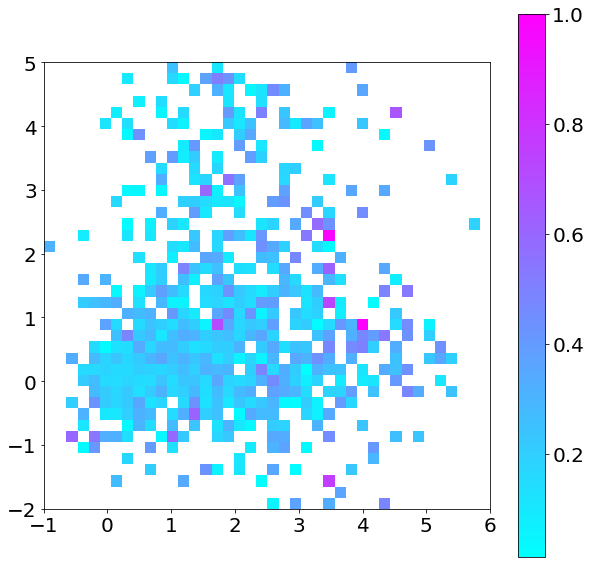

In [453]:
fig = plt.figure(figsize=(10,10))
plt.imshow(test['pc_binned'],cmap='cool',extent=(start_x,end_x,start_y,end_y))
plt.colorbar()

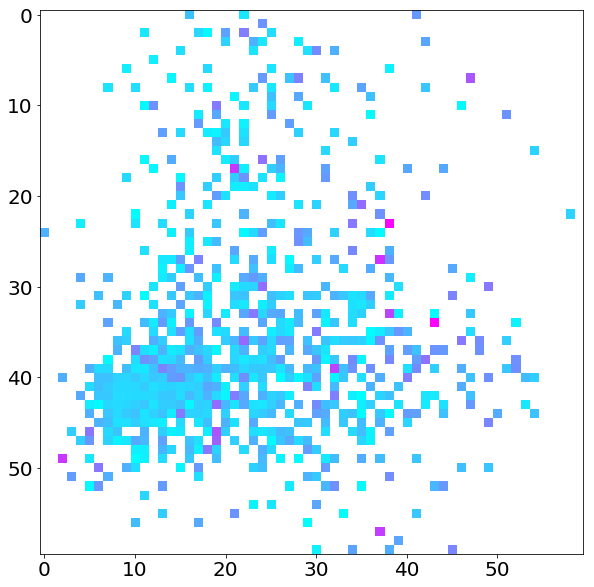

In [410]:
fig = plt.figure(figsize=(10,10))
plt.imshow(test['pc_binned'],cmap='cool')

ValueError: `bins` must increase monotonically, when an array

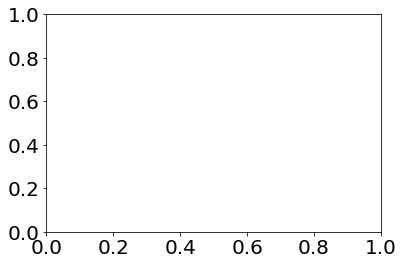

In [239]:
plt.hist(normalized,fictrac['Y']);

In [360]:
### code for binning voxel activity by behavior

x = fictrac['Z']
bins = np.array(np.arange(-2,5))
inds = np.digitize(x, bins)
centers = (bins[:-1] + bins[1:]) / 2

bin_avgs = []
for ind in np.unique(inds):
    bin_avgs.append(np.mean(normalized[np.where(ind==inds)]))

In [374]:
binned.statistic

array([0.3014562 , 0.2204973 , 0.16968316, 0.23019   , 0.23232685,
       0.22393481, 0.18623831, 0.35960349, 0.11167228, 0.2856571 ])

In [377]:
centers = (binned.bin_edges[:-1] + binned.bin_edges[1:]) / 2

In [365]:
data = fictrac['Z']
bins = np.linspace(-2, 7, 10)
digitized = np.digitize(data, bins)
bin_means = [data[digitized == i].mean() for i in range(1, len(bins))]

In [369]:
bins

array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.])

In [370]:
bin_means

[-1.3343311094523467,
 -0.1083287520945193,
 0.14390814620712275,
 1.3872346416519241,
 2.4892966079534493,
 3.5220688886145575,
 4.4401008472586065,
 5.383354895245507,
 6.405673033376258]

In [350]:
bins

array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,
        3.5,  4. ,  4.5])

In [351]:
centers

array([-1.75, -1.25, -0.75, -0.25,  0.25,  0.75,  1.25,  1.75,  2.25,
        2.75,  3.25,  3.75,  4.25])

In [352]:
bin_avgs

[0.3109513372506621,
 0.26548762992630215,
 0.2544425292973027,
 0.2381601332385287,
 0.16085612848695305,
 0.1727993994256966,
 0.25655873701750675,
 0.23598365755064002,
 0.2403973963475026,
 0.24612580724548136,
 0.23809706478267512,
 0.19800990815057998,
 0.21737365364388903,
 0.22825908921848276,
 0.2220221765953891]

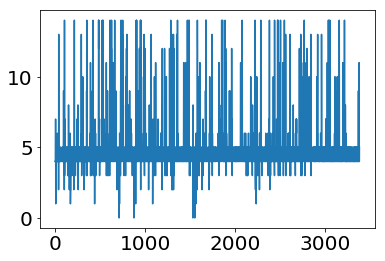

In [331]:
plt.plot(inds)

In [4]:
binned = scipy.stats.binned_statistic(x=acl, values=normalized, statistic='mean', bins=5, range=(-.1,.1))
centers = (binned.bin_edges[:-1] + binned.bin_edges[1:]) / 2

NameError: name 'acl' is not defined

NameError: name 'acl' is not defined

Text(0.5, 1.0, 'medulla voxel')

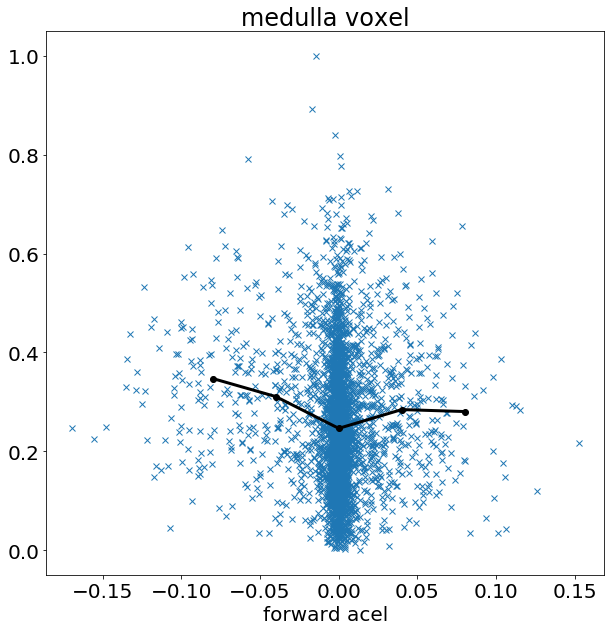

In [593]:
fig = plt.figure(figsize=(10,10))
plt.plot(acl,normalized,'x')
plt.plot(centers,binned.statistic,color='k',linewidth=3,marker='o')
#plt.text(x=-6,y=.6,s='FB Voxel activity',rotation=90)
plt.xlabel('forward acel')
plt.title('medulla voxel')

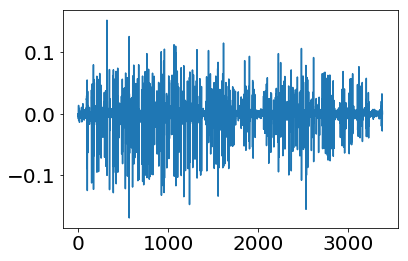

In [476]:
# want to look at the effects of acceleration
plt.plot(acl)

In [478]:
norm = mpl.colors.Normalize(vmin=0, vmax=0.5)
cmap = cm.cool
xss = cm.ScalarMappable(norm=norm, cmap=cmap)

norm = mpl.colors.Normalize(vmin=-0.05, vmax=0.05)
cmap = cm.binary
oss = cm.ScalarMappable(norm=norm, cmap=cmap)

In [506]:
import matplotlib.patches as mpatches

In [ ]:
for i in range(len(starts)):
    arrow = mpatches.FancyArrowPatch((x[starts][i],y[starts][i]),
                                     (x[stops][i],y[stops][i]),
                                     arrowstyle=style,
                                     zorder=2,
                                     color='k',
                                     alpha=1)
    ax.add_patch(arrow)

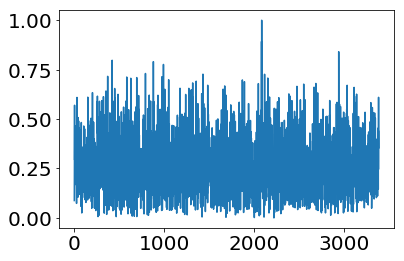

In [594]:
plt.plot(normalized)

(-3, 10)

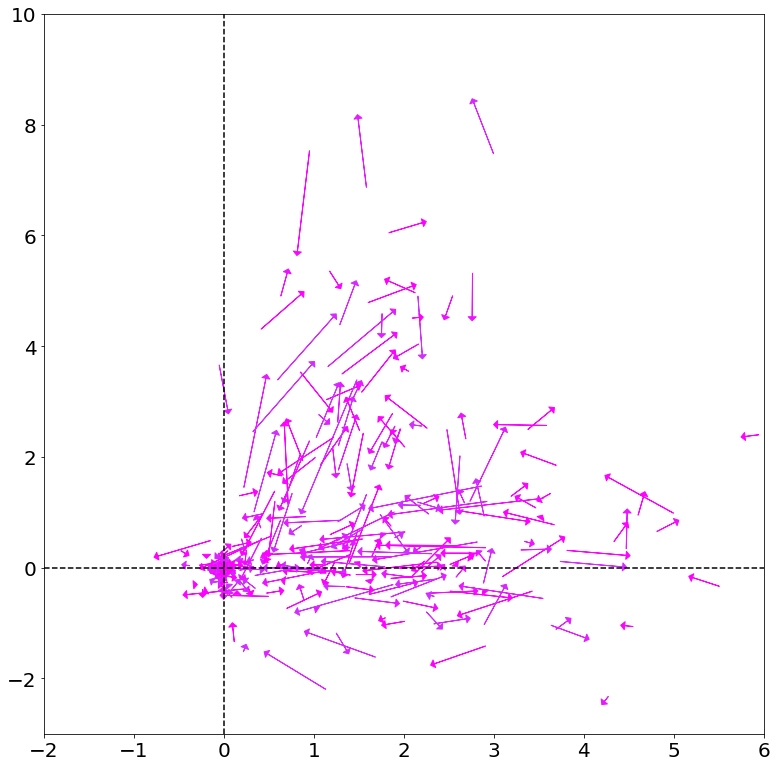

In [600]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
style="Simple,head_length=4,head_width=8,tail_width=.1"
for i in range(3384):
    #ax.plot(x[i],y[i],color=oss.to_rgba(acl[i]),marker='o',linestyle='-')
    #ax.plot(fictrac['Y'][i],fictrac['Z'][i],color=xss.to_rgba(normalized[i]),marker='x',linestyle='-')
    if normalized[i]>.4 and normalized[i]<.6:
        arrow = mpatches.FancyArrowPatch((fictrac_pre['Y'][i],fictrac_pre['Z'][i]),
                                     (fictrac_post['Y'][i],fictrac_post['Z'][i]),
                                     arrowstyle=style,
                                     zorder=2,
                                     color=xss.to_rgba(normalized[i]),
                                     alpha=1)
        ax.add_patch(arrow)
    
    #ax.plot(fictrac_pre['Y'][i],fictrac_pre['Z'][i],color=xss.to_rgba(normalized[i]),marker='x',linestyle='-')
    #ax.plot(fictrac_post['Y'][i],fictrac_post['Z'][i],color=xss.to_rgba(normalized[i]),marker='x',linestyle='-')

ax.axvline(0, linestyle='--', color='k')
ax.axhline(0, linestyle='--', color='k')
plt.xlim(-2,6)
plt.ylim(-3,10)

(-2, 2)

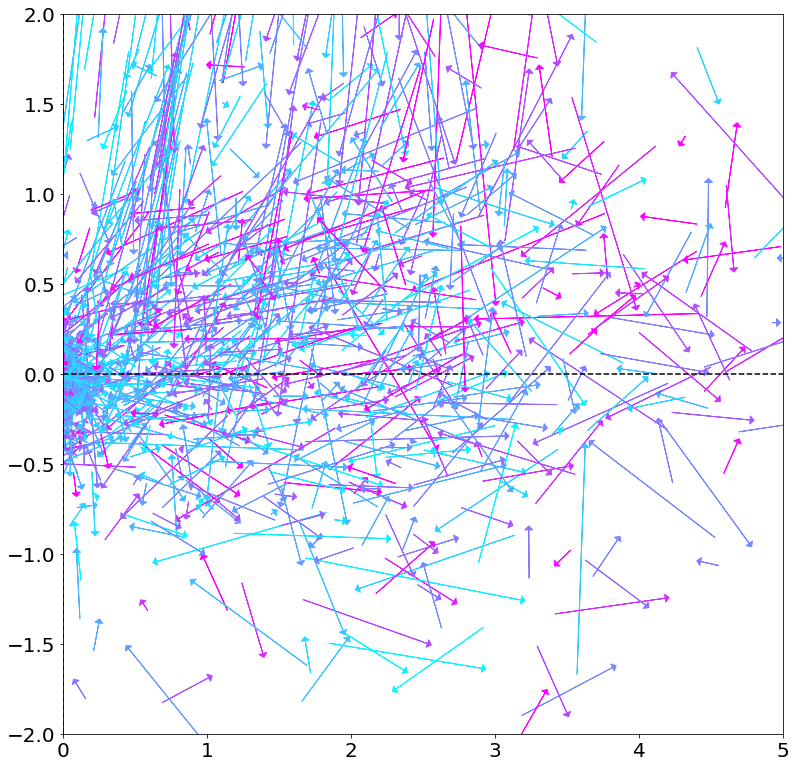

In [551]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
style="Simple,head_length=4,head_width=8,tail_width=.1"
for i in range(3384):
    #ax.plot(x[i],y[i],color=oss.to_rgba(acl[i]),marker='o',linestyle='-')
    #ax.plot(fictrac['Y'][i],fictrac['Z'][i],color=xss.to_rgba(normalized[i]),marker='x',linestyle='-')
    
    arrow = mpatches.FancyArrowPatch((fictrac_pre['Y'][i],fictrac_pre['Z'][i]),
                                 (fictrac_post['Y'][i],fictrac_post['Z'][i]),
                                 arrowstyle=style,
                                 zorder=2,
                                 color=xss.to_rgba(normalized[i]),
                                 alpha=1)
    ax.add_patch(arrow)
    
    #ax.plot(fictrac_pre['Y'][i],fictrac_pre['Z'][i],color=xss.to_rgba(normalized[i]),marker='x',linestyle='-')
    #ax.plot(fictrac_post['Y'][i],fictrac_post['Z'][i],color=xss.to_rgba(normalized[i]),marker='x',linestyle='-')

ax.axvline(0, linestyle='--', color='k')
ax.axhline(0, linestyle='--', color='k')
plt.xlim(0,5)
plt.ylim(-2,2)

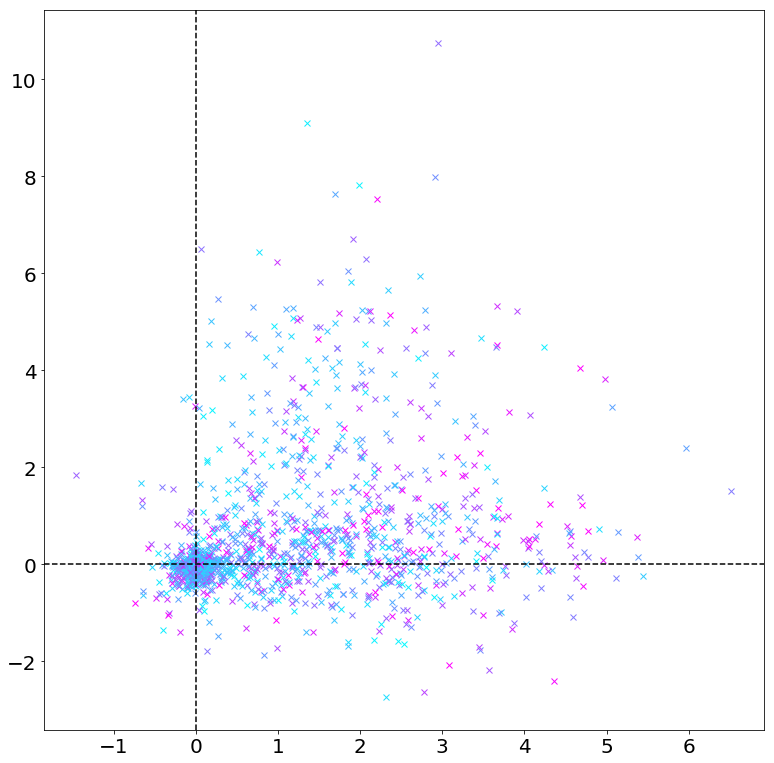

In [509]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
x=fictrac['Y']
y=fictrac['Z']
#cmap = cm.get_cmap(name='cool')
for i in range(3384):
    #ax.plot(x[i],y[i],color=oss.to_rgba(acl[i]),marker='o',linestyle='-')
    ax.plot(x[i],y[i],color=xss.to_rgba(normalized[i]),marker='x',linestyle='-')
#ax.plot(x[forward_times],y[forward_times],marker='o',linestyle='None')
#ax.plot(x[rotation_pos_times],y[rotation_pos_times],marker='o',linestyle='None')
#ax.plot(x[rotation_neg_times],y[rotation_neg_times],marker='o',linestyle='None')
#ax.plot(x[stop_times],y[stop_times],marker='o',linestyle='None')

ax.axvline(0, linestyle='--', color='k')
ax.axhline(0, linestyle='--', color='k')

In [118]:
cmap = cm.get_cmap(name='rainbow')
cmap(10)

(0.4215686274509804, 0.12288829066471411, 0.9981033287370441, 1.0)

In [174]:
cm.cool(.33)

(0.32941176470588235, 0.6705882352941177, 1.0, 1.0)

In [219]:
one_slice.shape

(32768, 3384)

In [223]:
corrs = []
for i in range(32768):
    corrs.append(scipy.stats.pearsonr(fictrac['Y'], one_slice[i,:])[0])

In [226]:
np.max(np.nan_to_num(corrs))

0.2589456495898812

In [139]:
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(model.labels_==cluster_num)[0]
    colored_by_betas[cluster_indicies] = corrs[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)

In [141]:
background = np.copy(colored_by_betas)

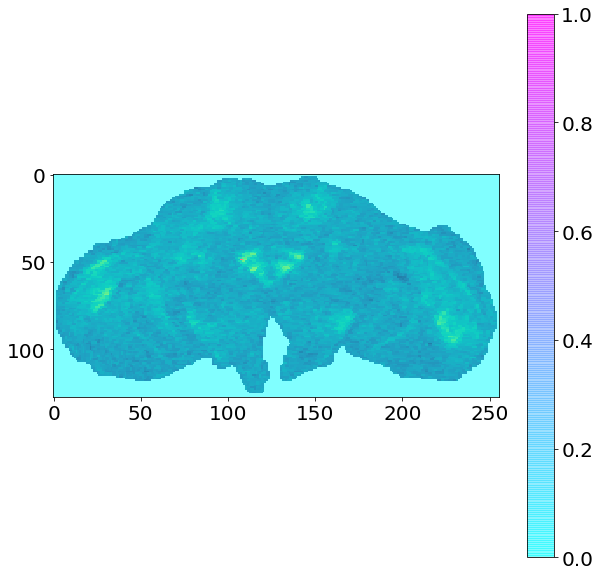

In [146]:
plt.figure(figsize=(10,10))
plt.imshow(background.T)
plt.imshow(colored_by_betas.T,cmap="cool",alpha=.5)
plt.colorbar()

AttributeError: 'list' object has no attribute 'shape'

In [135]:
np.argmax(np.nan_to_num(corrs))

2083

In [133]:
colored_by_betas.shape

(256, 128)

In [143]:
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(model.labels_==cluster_num)[0]
    if cluster_num == np.argmax(np.nan_to_num(corrs)):
        colored_by_betas[cluster_indicies] = 1
    else:
        colored_by_betas[cluster_indicies] = 0
colored_by_betas = colored_by_betas.reshape(256,128)

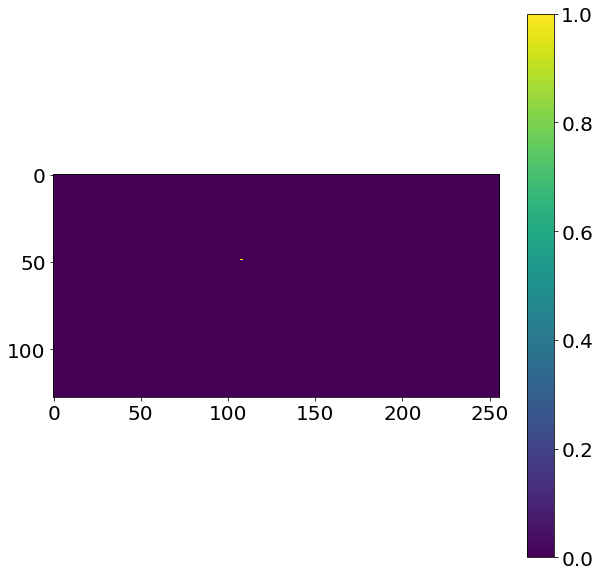

In [144]:
plt.figure(figsize=(10,10))
plt.imshow(colored_by_betas.T)
plt.colorbar()